## Computing CO cross section using HITRAN

This tutorial demonstrates how to compute the opacity of CO using HITRAN step by step.

In [1]:
from exojax.spec import xsection
from exojax.spec.hitran import SijT, doppler_sigma, gamma_hitran, gamma_natural
from exojax.spec import moldb
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('bmh')

/home/kawahara/anaconda3/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


First of all, set a wavenumber bin in the unit of wavenumber (cm-1).
Here we set the wavenumber range as $1000 \le \nu \le 10000$ (1/cm) with the resolution of 0.01 (1/cm). 

We call moldb instance with the path of par file.
If the par file does not exist, moldb will try to download it from HITRAN website.

In [5]:
# Setting wavenumber bins and loading HITRAN database
nus=np.linspace(1000.0,10000.0,900000,dtype=np.float64) #cm-1
mdbCO=moldb.MdbHit('/home/kawahara/exojax/data/CO/05_hit12.par',nus)

Define molecular weight of CO ($\sim 12+16=28$), temperature (K), and pressure (bar).
Also, we here assume the 100 % CO atmosphere, i.e. the partial pressure = pressure.  

In [6]:
Mmol=28.010446441149536 # molecular weight
Tfix=1000.0 # we assume T=1000K
Pfix=1.e-3 # we compute P=1.e-3 bar
Ppart=Pfix #partial pressure of CO. here we assume a 100% CO atmosphere. 

partition function ratio $q(T)$ is defined by 

$q(T) = Q(T)/Q(T_{ref})$; $T_{ref}$=296 K

Here, we use the partition function from HAPI

In [7]:
import jax.numpy as jnp
qt=mdbCO.Qr_layer_HAPI(jnp.array([Tfix]))[0]

In [8]:
np.shape(qt)

(3977,)

Let us compute the line strength S(T) at temperature of Tfix.

$S (T;s_0,\nu_0,E_l,q(T)) = S_0 \frac{Q(T_{ref})}{Q(T)} \frac{e^{- h c E_l /k_B T}}{e^{- h c E_l /k_B T_{ref}}} \frac{1- e^{- h c \nu /k_B T}}{1-e^{- h c \nu /k_B T_{ref}}}= q_r(T)^{-1} e^{ s_0 - c_2 E_l (T^{-1} - T_{ref}^{-1})}  \frac{1- e^{- c_2 \nu_0/ T}}{1-e^{- c_2 \nu_0/T_{ref}}}$

$s_0=\log_{e} S_0$ : logsij0

$\nu_0$: nu_lines

$E_l$ : elower

Why the input is $s_0 = \log_{e} S_0$ instead of $S_0$ in SijT? This is because the direct value of $S_0$ is quite small and we need to use float32 for jax.  

In [9]:
Sij=SijT(Tfix,mdbCO.logsij0,mdbCO.nu_lines,mdbCO.elower,qt)

Then, compute the Lorentz gamma factor (pressure+natural broadening)

$\gamma_L = \gamma^p_L + \gamma^n_L$

where the pressure broadning 

$\gamma^p_L = (T/296K)^{-n_{air}} [ \alpha_{air} ( P - P_{part})/P_{atm} + \alpha_{self} P_{part}/P_{atm}]$

$P_{atm}$: 1 atm in the unit of bar (i.e. = 1.01325)

and the natural broadening

$\gamma^n_L = \frac{A}{4 \pi c}$

In [10]:
gammaL = gamma_hitran(Pfix,Tfix, Ppart, mdbCO.n_air, \
                      mdbCO.gamma_air, mdbCO.gamma_self) \
+ gamma_natural(mdbCO.A) 

Thermal broadening

$\sigma_D^{t} = \sqrt{\frac{k_B T}{M m_u}} \frac{\nu_0}{c}$

In [11]:
# thermal doppler sigma
sigmaD=doppler_sigma(mdbCO.nu_lines,Tfix,Mmol)

Then, the line center...

In HITRAN database, a slight pressure shift can be included using $\delta_{air}$:
$\nu_0(P) = \nu_0 + \delta_{air} P$. But this shift is quite a bit. 

In [12]:
#line center
nu0=mdbCO.nu_lines

#Use below if you wanna include a slight pressure line shift
#nu0=mdbCO.nu_lines+mdbCO.delta_air*Pfix 

Although it depends on your GPU, you might need to devide the computation into multiple loops because of the limitation of the GPU memory. Here we assume 30MB for GPU memory (not exactly, memory size for numatrix). 

In [13]:
xsv=xsection(nus,nu0,sigmaD,gammaL,Sij,memory_size=30) #use 30MB GPU MEMORY for numax

100%|██████████| 456/456 [00:12<00:00, 36.43it/s]


Plot it!

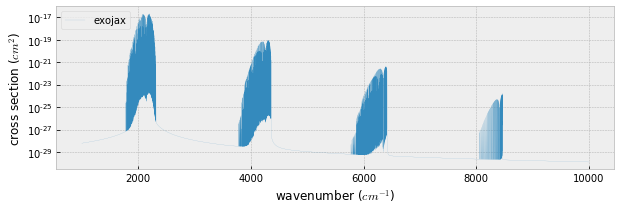

In [14]:
fig=plt.figure(figsize=(10,3))
ax=fig.add_subplot(111)
plt.plot(nus,xsv,lw=0.1,label="exojax")
plt.yscale("log")
plt.xlabel("wavenumber ($cm^{-1}$)")
plt.ylabel("cross section ($cm^{2}$)")
plt.legend(loc="upper left")
plt.savefig("co_hitran.pdf", bbox_inches="tight", pad_inches=0.0)
plt.show()

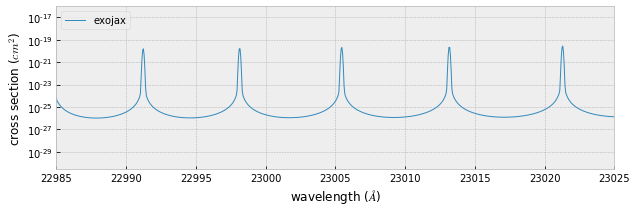

In [15]:
fig=plt.figure(figsize=(10,3))
ax=fig.add_subplot(111)
plt.plot(1.e8/nus,xsv,lw=1,label="exojax")
plt.yscale("log")
plt.xlabel("wavelength ($\AA$)")
plt.ylabel("cross section ($cm^{2}$)")
plt.xlim(22985.,23025)
plt.legend(loc="upper left")
plt.savefig("co_hitran.pdf", bbox_inches="tight", pad_inches=0.0)
plt.show()

### Important Note

Use float64 for wavenumber bin and line center.

Below, we see the difference of opacity between float64 case and float 32.

In [16]:
xsv_32=xsection(np.float32(nus),np.float32(nu0),sigmaD,gammaL,Sij,memory_size=30) 

100%|██████████| 456/456 [00:06<00:00, 68.35it/s]

Warning!: nu is not np.float64 but  float32


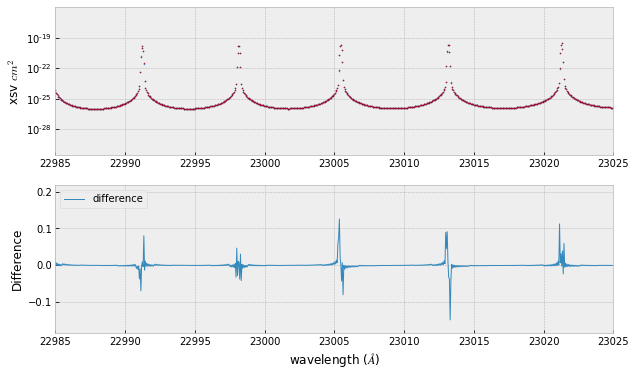

In [17]:
fig=plt.figure(figsize=(10,6))
ax=fig.add_subplot(211)
plt.plot(1.e8/nus,xsv,".",lw=1,label="64",markersize=1)
plt.plot(1.e8/nus,xsv_32,".",lw=1,label="32",markersize=1)
plt.xlim(22985.,23025)
plt.yscale("log")
plt.ylabel("xsv $cm^{2}$")
ax=fig.add_subplot(212)
plt.plot(1.e8/nus,(xsv_32-xsv)/xsv,lw=1,label="difference")
plt.xlabel("wavelength ($\AA$)")
plt.ylabel("Difference")
plt.xlim(22985.,23025)
plt.legend(loc="upper left")
plt.show()

We found ~ 10 % error when using float32 as an wavenumber and line center